In [2]:
# First Task: Exploratory Data Analysis
import os
import pandas as pd
df = pd.DataFrame(pd.read_csv('sample_data.csv', header = 0))
df.fillna(0, inplace = True)
#df.info()

def handle_missing_value(x): # x = 20, i.e. the column 'TotalCharges'.
    # Handle some missing values, which are blank characters, preventing us to convert string to float.
    # For example, see Line 490 in CSV file.
    # I cannot use float() function or .astype() function if there exists blank characters.
    for z in range(len(df[df.columns[x]])):        
        if df[df.columns[x]][z] == " ":
            if df['Contract'][z] == "Month-to-month":
                df.replace({df.columns[x]: 
                            {df[df.columns[x]][z]: float(df['MonthlyCharges'][z])*1}},
                            inplace = True
                            )
            elif df['Contract'][z] == "One year":
                df.replace({df.columns[x]: 
                            {df[df.columns[x]][z]: float(df['MonthlyCharges'][z])*12}},
                            inplace = True
                            )
            elif df['Contract'][z] == "Two year":
                df.replace({df.columns[x]: 
                            {df[df.columns[x]][z]: float(df['MonthlyCharges'][z])*24}},
                            inplace = True
                            )

def convert_string_to_value(x): # Map strings to corresponding values, which is ranged from -1 to 1
    column = df.groupby(df.columns[x]).apply(list).reset_index()
    for y in range(len(column[df.columns[x]])):
        df.replace({df.columns[x]:
                    {
                        column[df.columns[x]][y]:
                        float("{:.1f}".format(-1 + y*2/(len(column[df.columns[x]]) - 1)))
                     }
                    },
                   inplace = True)
"""
Example: Column 'MultipleLines' contains three distinct elements: 'No', 'No phone service' and 'Yes'. 
Their values (after being converted) are: -1, 0 and 1, respectively.
"""
def convert_value_to_float():
    for x in range(2,22):
        df[df.columns[x]] = pd.to_numeric(df[df.columns[x]], errors='coerce')
        
def scale_value(x): # So all values will be ranged from -1 to 1. Use for training models
    scale = []
    #df[df.columns[x]] = pd.to_numeric(df[df.columns[x]], errors='coerce')
    for z in range(len(df[df.columns[x]])):
        scale.append(float( "{:.4f}".format( df[df.columns[x]][z] / (df[df.columns[x]].max())  )  )  )
    return scale
                  
    
# Pre-process DataFrame
handle_missing_value(20) # You have to do this before converting string.


for i in range(22):
    if i in [0,1,6,19,20]:
        pass
    else:
        convert_string_to_value(i)

        
convert_value_to_float() #Do this before scaling values.


for i in [6,19,20]:
    df[f'New_{df.columns[i]}'] = scale_value(i)

In [7]:
# Second Task: Correlations to the target values
Column_name = []
Correlation = []
Absolute_value = []

for x in range(2,21):
    Column_name.append(df.columns[x])
    Correlation.append(float( "{:.4f}".format(df['target'].corr(df[df.columns[x]])  )  )  )
    Absolute_value.append(abs(float( "{:.4f}".format(df['target'].corr(df[df.columns[x]])  )  )  )  )
    
df2 = pd.DataFrame(data={'Column_name': Column_name, 'Correlation': Correlation, 'Absolute_value': Absolute_value})

df2.sort_values(by='Absolute_value', ascending=False).reset_index()

,index,Column_name,Correlation,Absolute_value
0,14,Contract,-0.3967,0.3967
1,4,tenure,-0.3522,0.3522
2,8,OnlineSecurity,-0.2893,0.2893
3,11,TechSupport,-0.2825,0.2825
4,18,TotalCharges,-0.1990,0.1990
5,9,OnlineBackup,-0.1955,0.1955
6,17,MonthlyCharges,0.1934,0.1934
7,15,PaperlessBilling,0.1918,0.1918
8,10,DeviceProtection,-0.1781,0.1781
9,3,Dependents,-0.1642,0.1642


Accuracy of Logistic Regression: 0.7936583057264552


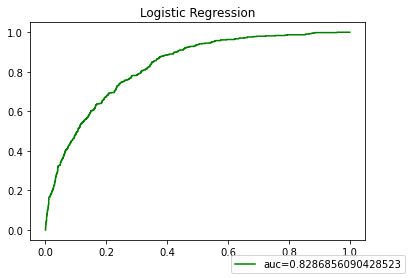

In [58]:
# Third Task: Build a prediction model
feature_columns = []
for k in range(25):
    if k not in [0, 1, 6, 19, 20, 21]:
        feature_columns.append(df.columns[k])
        
X = df[feature_columns]
y = df[df.columns[21]] # target column

# Build a logistic regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Accuracy report
from sklearn import metrics
print("Accuracy of Logistic Regression:",metrics.accuracy_score(y_test, y_pred))

# AUC-ROC
import matplotlib.pyplot as plt
logistic = plt.figure(1)
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc), color = 'green')
logistic.legend(loc='lower right')
plt.title('Logistic Regression')
#plt.savefig('logistic.png')
plt.show()